# Panan01 surface fluxes in AABW formation regions

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38845/status,
Dashboard: /proxy/38845/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34429,Workers: 28
Dashboard: /proxy/38845/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:36335,Total threads: 1
Dashboard: /proxy/34639/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:33693,


In [4]:
#Importing data
pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean_month.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean_month.nc'))

In [5]:
## Creating shelf mask another way

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [9]:
lat_slice = slice(None,-59)
time_slice = slice('1910-01-01','1919-12-31')

In [10]:
# Time variant variables
def preprocess_1(ds):
    ds = ds[['pme_river','sfc_salt_flux_ice','sfc_salt_flux_restore']].where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess_1, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess_1, chunks = 'auto')

In [11]:
cont = cont.sel(time= time_slice)
melt = melt.sel(time = time_slice)

In [12]:
# Area
area = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']
var = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean.nc')['salt'].isel(st_ocean=0,time=0).where(shelf_mask ==1) 

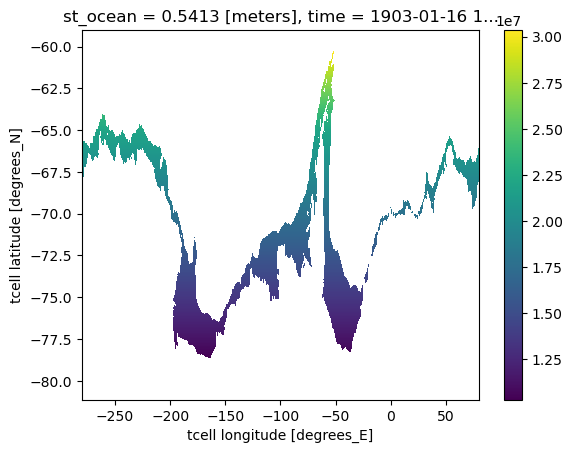

In [13]:
area_corr = area*(var*0 +1)
area_corr.plot()

### Creating the regions

In [14]:
# Define in longitude space what the cut-off values for regions should be.
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
AmW = -150
AmE = -100
BeW = -100
BeE = -65

WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

Adelie = slice(AdelieW,AdelieE)
Ross = slice(RossW, RossE)
Am = slice(AmW, AmE)
Be = slice(BeW,BeE)
Weddell = slice(WeddellW, WeddellE)
Prydz = slice(PrydzW, PrydzE)

In [15]:
area_Adelie = area_corr.sel(xt_ocean=Adelie).where(shelf_mask == 1)
area_Ross = area_corr.sel(xt_ocean=Ross).where(shelf_mask == 1)
area_Am = area_corr.sel(xt_ocean=Am).where(shelf_mask == 1)
area_Be = area_corr.sel(xt_ocean=Be).where(shelf_mask == 1)
area_Weddell = area_corr.sel(xt_ocean=Weddell).where(shelf_mask == 1)
area_Prydz = area_corr.sel(xt_ocean=Prydz).where(shelf_mask == 1)

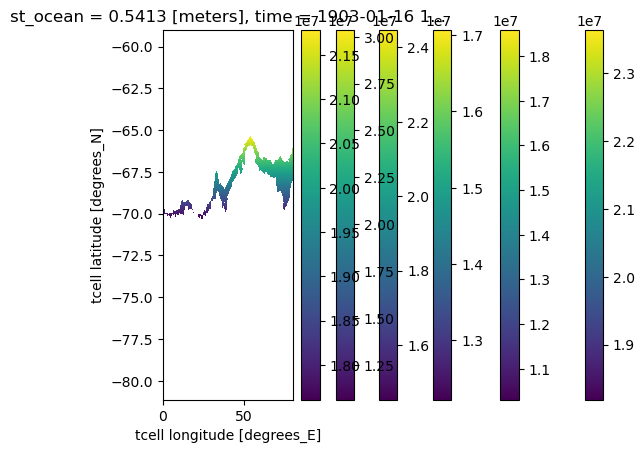

In [16]:
area_Adelie.plot()
area_Ross.plot()
area_Am.plot()
area_Be.plot()
area_Weddell.plot()
area_Prydz.plot()

### Fluxes

In [17]:
water_C = cont['pme_river']
water_M = melt['pme_river']

salt_C = cont['sfc_salt_flux_ice'] + cont['sfc_salt_flux_restore']
salt_M = melt['sfc_salt_flux_ice'] + melt['sfc_salt_flux_restore']

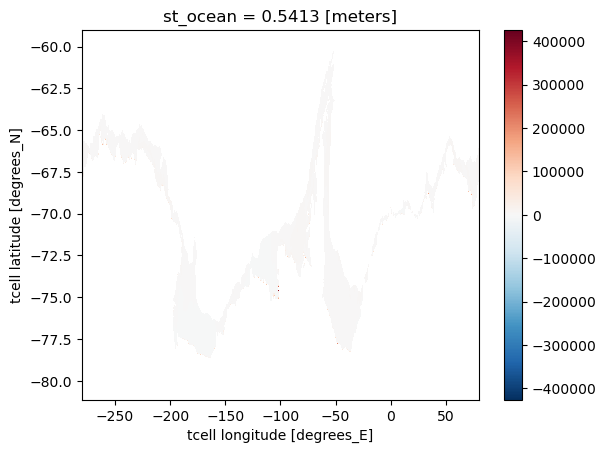

In [18]:
# Checking mask
(area_corr * water_C.isel(time=0)).plot()

### Time series

In [36]:
# Did this cell with salt first
# Restricting to regions
botsalt_cont_1 = water_C.sel(xt_ocean=Adelie)
botsalt_pert_1 = water_M.sel(xt_ocean=Adelie)

botsalt_cont_2 = water_C.sel(xt_ocean=Ross)
botsalt_pert_2 = water_M.sel(xt_ocean=Ross)

botsalt_cont_3 = water_C.sel(xt_ocean=Am)
botsalt_pert_3 = water_M.sel(xt_ocean=Am)

botsalt_cont_4 = water_C.sel(xt_ocean=Be)
botsalt_pert_4 = water_M.sel(xt_ocean=Be)

botsalt_cont_5 = water_C.sel(xt_ocean=Weddell)
botsalt_pert_5 = water_M.sel(xt_ocean=Weddell)

botsalt_cont_6 = water_C.sel(xt_ocean=Prydz)
botsalt_pert_6 = water_M.sel(xt_ocean=Prydz)

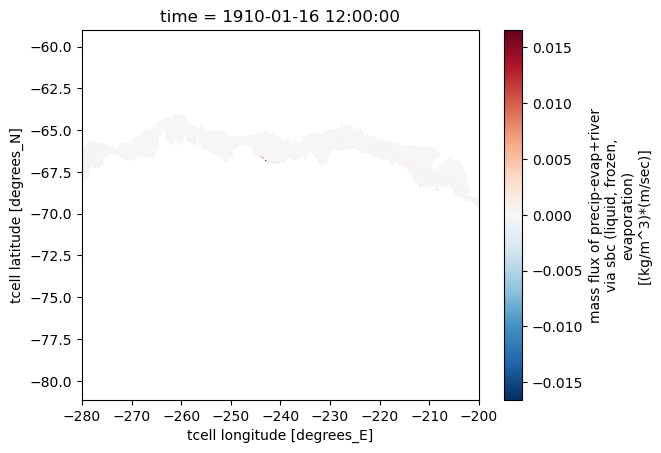

In [37]:
botsalt_cont_1.isel(time=0).plot()

In [38]:
# Spatial averages
botsalt_cont_1_time = (area_corr * botsalt_cont_1).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Adelie).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_1_time = (area_corr * botsalt_pert_1).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Adelie).sum(['xt_ocean', 'yt_ocean'])

botsalt_cont_2_time = (area_corr * botsalt_cont_2).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Ross).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_2_time = (area_corr * botsalt_pert_2).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Ross).sum(['xt_ocean', 'yt_ocean'])

botsalt_cont_3_time = (area_corr * botsalt_cont_3).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Am).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_3_time = (area_corr * botsalt_pert_3).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Am).sum(['xt_ocean', 'yt_ocean'])

botsalt_cont_4_time = (area_corr * botsalt_cont_4).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Be).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_4_time = (area_corr * botsalt_pert_4).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Be).sum(['xt_ocean', 'yt_ocean'])

botsalt_cont_5_time = (area_corr * botsalt_cont_5).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Weddell).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_5_time = (area_corr * botsalt_pert_5).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Weddell).sum(['xt_ocean', 'yt_ocean'])

botsalt_cont_6_time = (area_corr * botsalt_cont_6).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Prydz).sum(['xt_ocean', 'yt_ocean'])
botsalt_pert_6_time = (area_corr * botsalt_pert_6).sum(['xt_ocean', 'yt_ocean']) / area_corr.sel(xt_ocean=Prydz).sum(['xt_ocean', 'yt_ocean'])


In [39]:
# Check shape
botsalt_cont_1_time

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00

In [40]:
botsalt_cont_1_time = botsalt_cont_1_time.load()
botsalt_pert_1_time = botsalt_pert_1_time.load()

In [41]:
botsalt_cont_2_time = botsalt_cont_2_time.load()
botsalt_pert_2_time = botsalt_pert_2_time.load()

In [42]:
botsalt_cont_3_time = botsalt_cont_3_time.load()
botsalt_pert_3_time = botsalt_pert_3_time.load()

In [43]:
botsalt_cont_4_time = botsalt_cont_4_time.load()
botsalt_pert_4_time = botsalt_pert_4_time.load()

In [44]:
botsalt_cont_5_time = botsalt_cont_5_time.load()
botsalt_pert_5_time = botsalt_pert_5_time.load()

In [45]:
botsalt_cont_6_time = botsalt_cont_6_time.load()
botsalt_pert_6_time = botsalt_pert_6_time.load()

In [46]:
botsalt_anom_1_time = botsalt_pert_1_time - botsalt_cont_1_time
botsalt_anom_1_time = botsalt_anom_1_time.load()
botsalt_anom_1_time.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/wfo_anom_Adelie_prescribed_ACCESS.nc')

In [47]:
botsalt_anom_2_time = botsalt_pert_2_time - botsalt_cont_2_time
botsalt_anom_2_time = botsalt_anom_2_time.load()
botsalt_anom_2_time.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/wfo_anom_Ross_prescribed_ACCESS.nc')

In [48]:
botsalt_anom_3_time = botsalt_pert_3_time - botsalt_cont_3_time
botsalt_anom_3_time = botsalt_anom_3_time.load()
botsalt_anom_3_time.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/wfo_anom_Am_prescribed_ACCESS.nc')

In [49]:
botsalt_anom_4_time = botsalt_pert_4_time - botsalt_cont_4_time
botsalt_anom_4_time = botsalt_anom_4_time.load()
botsalt_anom_4_time.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/wfo_anom_Be_prescribed_ACCESS.nc')

In [50]:
botsalt_anom_5_time = botsalt_pert_5_time - botsalt_cont_5_time
botsalt_anom_5_time = botsalt_anom_5_time.load()
botsalt_anom_5_time.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/wfo_anom_Weddell_prescribed_ACCESS.nc')

In [51]:
botsalt_anom_6_time = botsalt_pert_6_time - botsalt_cont_6_time
botsalt_anom_6_time = botsalt_anom_6_time.load()
botsalt_anom_6_time.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/wfo_anom_Prydz_prescribed_ACCESS.nc')

#### Plotting all

Text(0.5, 1.0, 'ACCESS-OM2 Time Series of salt flux on Shelf, formation regions')

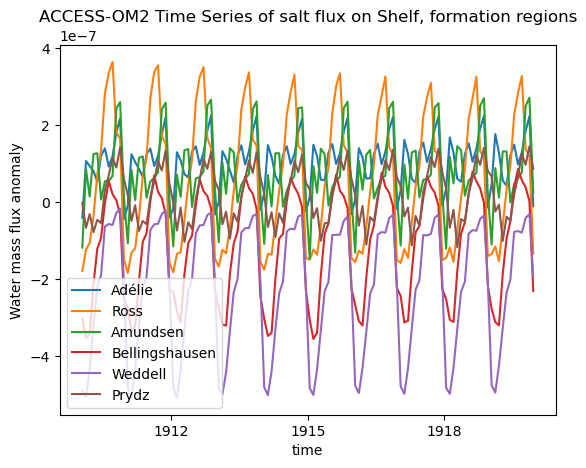

In [35]:
botsalt_anom_1_time.plot(label="Adélie")
botsalt_anom_2_time.plot(label="Ross")
botsalt_anom_3_time.plot(label="Amundsen")
botsalt_anom_4_time.plot(label="Bellingshausen")
botsalt_anom_5_time.plot(label="Weddell")
botsalt_anom_6_time.plot(label="Prydz")
plt.ylabel("Water mass flux anomaly")
plt.legend(loc="lower left")
plt.title("ACCESS-OM2 Time Series of salt flux on Shelf, formation regions")


Text(0.5, 1.0, 'ACCESS-OM2 Time Series of wfo on Shelf, formation regions')

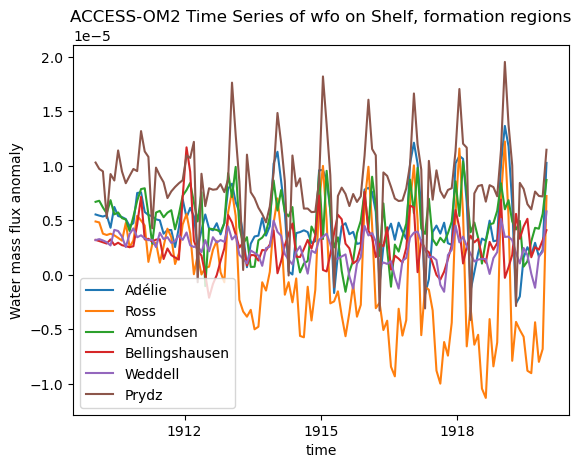

In [52]:
botsalt_anom_1_time.plot(label="Adélie")
botsalt_anom_2_time.plot(label="Ross")
botsalt_anom_3_time.plot(label="Amundsen")
botsalt_anom_4_time.plot(label="Bellingshausen")
botsalt_anom_5_time.plot(label="Weddell")
botsalt_anom_6_time.plot(label="Prydz")
plt.ylabel("Water mass flux anomaly")
plt.legend(loc="lower left")
plt.title("ACCESS-OM2 Time Series of wfo on Shelf, formation regions")
